## Project of Green AI

LOUDIYI Nassim

LU-YEN-TUNG Paul Adrien

MACCIONE Gabriel

MALONGO Cyrille

MARONNE Julien

## Installation

Liste of all libraries to import

In [3]:
# Libraries for file and folder handling
import os
import csv
import shutil
import random

# Libraries for data handling and CSV
import pandas as pd
import numpy as np
import seaborn as sns

# Libraries for visualization
import matplotlib.pyplot as plt
from PIL import Image

# Libraries for deep learning and image processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Librairies for training and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


Install required libraries via pip if not already installed


In [ ]:
# for data handling and CSV
!pip install pandas
!pip install numpy

# for deep learning and image processing
!pip install tensorflow
!pip install pillow

# for the visualization
!pip install matplotlib
!pip install seaborn

# for the metrics
!pip install scikit-learn

## Exploration

In [4]:
base_dir = r"C:\Users\Gabriel\Documents\Green AI\realwaste\realwaste-main\RealWaste"
csv_path = os.path.join(base_dir, "annotations.csv")

with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "label"])

    for label in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, label)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    writer.writerow([os.path.join(label, file), label])

print(f"✅ Fichier CSV créé : {csv_path}")


✅ Fichier CSV créé : C:\Users\Gabriel\Documents\Green AI\realwaste\realwaste-main\RealWaste\annotations.csv


The preview of the dataset

In [5]:
# Read the CSV file
df = pd.read_csv(csv_path)

# Preview the CSV
print("Dataset preview:")
print(df.head(), "\n")

# Dataset dimensions
print("Total number of images:", len(df))
print("Number of classes:", df['label'].nunique(), "\n")

Dataset preview:
                      filename      label
0    Cardboard\Cardboard_1.jpg  Cardboard
1   Cardboard\Cardboard_10.jpg  Cardboard
2  Cardboard\Cardboard_100.jpg  Cardboard
3  Cardboard\Cardboard_101.jpg  Cardboard
4  Cardboard\Cardboard_102.jpg  Cardboard 

Total number of images: 4752
Number of classes: 9 



In [9]:
df.info

<bound method DataFrame.info of                           filename       label
0        Cardboard\Cardboard_1.jpg   Cardboard
1       Cardboard\Cardboard_10.jpg   Cardboard
2      Cardboard\Cardboard_100.jpg   Cardboard
3      Cardboard\Cardboard_101.jpg   Cardboard
4      Cardboard\Cardboard_102.jpg   Cardboard
...                            ...         ...
4747  Vegetation\Vegetation_95.jpg  Vegetation
4748  Vegetation\Vegetation_96.jpg  Vegetation
4749  Vegetation\Vegetation_97.jpg  Vegetation
4750  Vegetation\Vegetation_98.jpg  Vegetation
4751  Vegetation\Vegetation_99.jpg  Vegetation

[4752 rows x 2 columns]>

Here is the Class distribution

In [11]:
# Class distribution
class_counts = df['label'].value_counts()
print("Class distribution:")
print(class_counts)


Class distribution:
label
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64


# Vizualisation

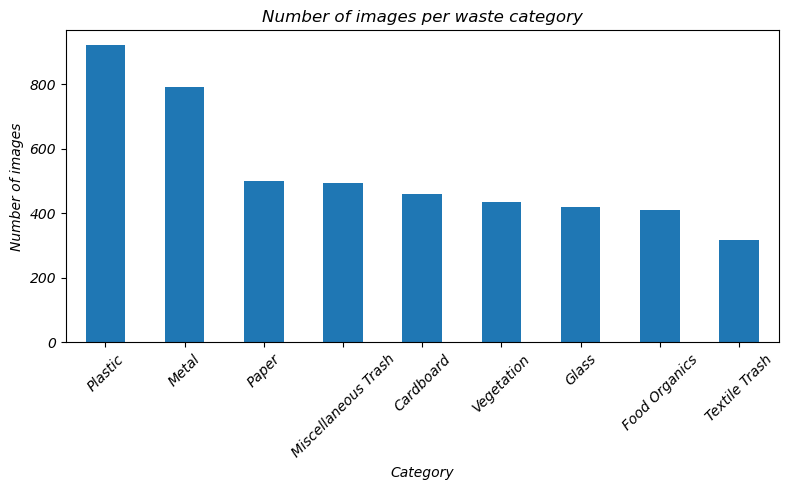

In [12]:
# Visualization of class distribution
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar')
plt.title("Number of images per waste category")
plt.xlabel("Category")
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here some random pictures in order to have an idea of the content of the dataset

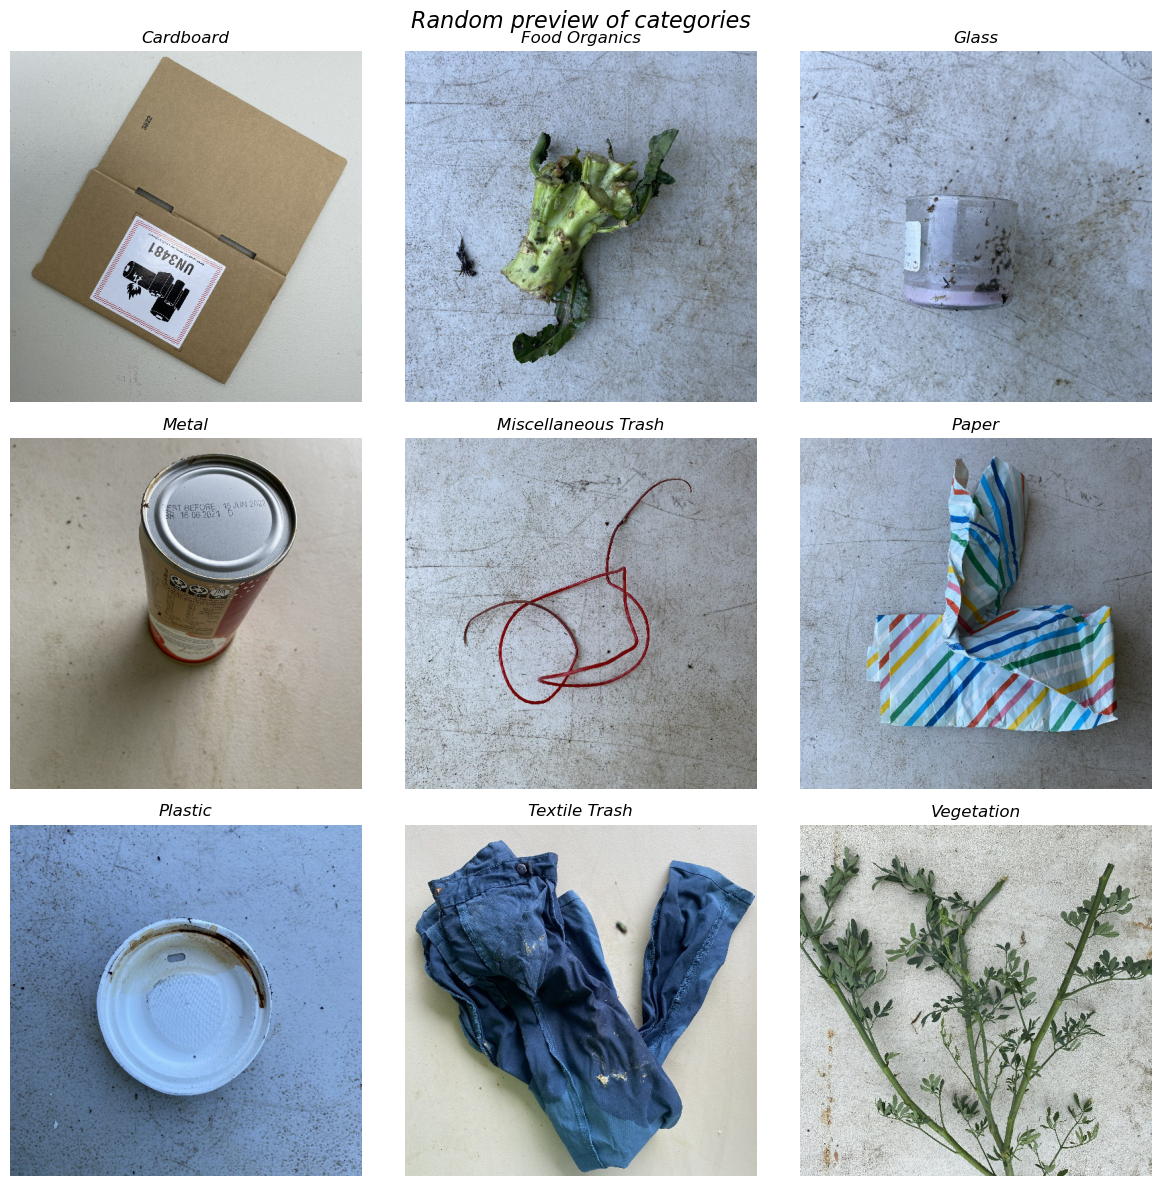

In [13]:
# Random preview of images
num_classes = len(df['label'].unique())
cols = 3
rows = (num_classes // cols) + 1

plt.figure(figsize=(12, 4 * rows))

for i, label in enumerate(df['label'].unique()):
    sample = df[df['label'] == label].sample(1).iloc[0]
    img_path = os.path.join(base_dir, sample['filename'])
    
    try:
        img = Image.open(img_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    except Exception as e:
        print(f"Error on {img_path} : {e}")

plt.suptitle("Random preview of categories", fontsize=16)
plt.tight_layout()
plt.show()


All images have objects (waste items) photographed on a mostly plain background.

Images generally show waste items on a solid or uniform background.

Each photo contains a single object with a simple, uncluttered background.

Let's check now the shape of the pictures

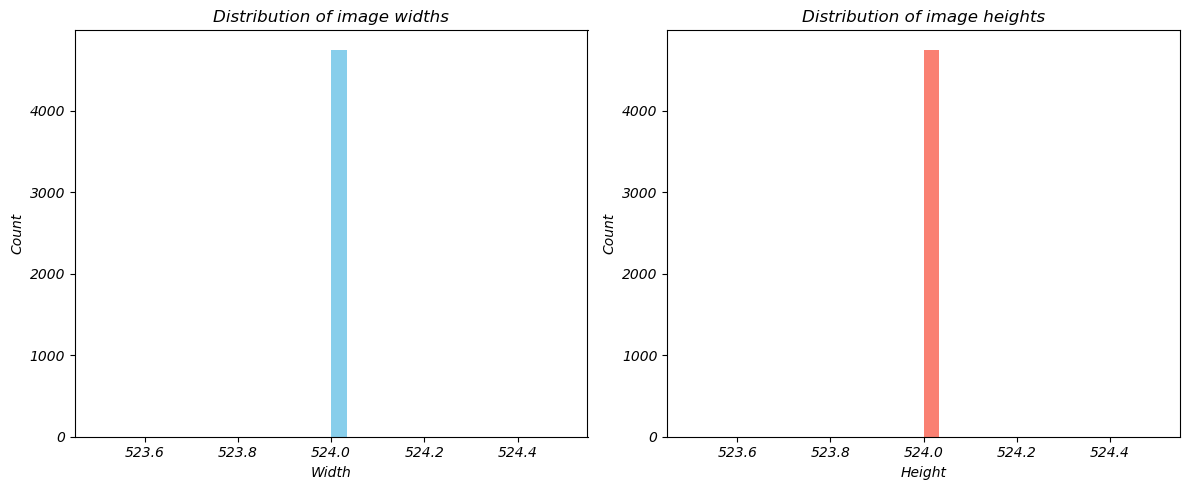

In [15]:
widths, heights = [], []

for filename in df['filename']:
    try:
        img = Image.open(os.path.join(base_dir, filename))
        widths.append(img.width)
        heights.append(img.height)
    except:
        continue

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='skyblue')
plt.title("Distribution of image widths")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='salmon')
plt.title("Distribution of image heights")
plt.xlabel("Height")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


All the images are already square, with a size of 524×524 pixels so it's pretty good for the study

Let's check the color of the pictures 

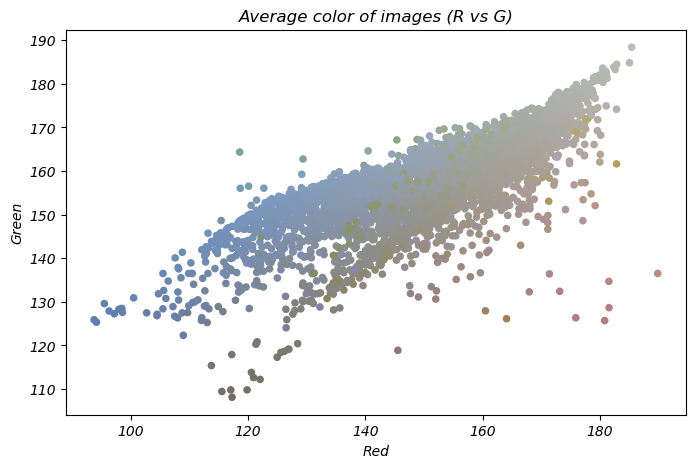

In [16]:
avg_colors = []

for filename in df['filename']:
    try:
        img = Image.open(os.path.join(base_dir, filename))
        avg_color = np.array(img).mean(axis=(0,1))[:3]  # RGB
        avg_colors.append(avg_color)
    except:
        continue

avg_colors = np.array(avg_colors)

plt.figure(figsize=(8,5))
plt.scatter(avg_colors[:,0], avg_colors[:,1], c=avg_colors/255, s=20)
plt.xlabel("Red")
plt.ylabel("Green")
plt.title("Average color of images (R vs G)")
plt.show()


The diagonal between red and green suggests that your dataset has a lot of earthy, yellowish, or greenish tones, which makes sense for waste items and a mostly uniform background.

# Cleaning

Let's check if there are corrupted pictures 

In [12]:
bad_files = []
for f in df['filename']:
    path = os.path.join(base_dir, f)
    try:
        with Image.open(path) as img:
            img.verify()
    except:
        bad_files.append(f)

print("Corrupted pictures :", len(bad_files))


Images corrompues : 0


# Pre processing

We split the dataset 

In [6]:
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Split the data (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"Training set: {len(train_df)} images")
print(f"Test set: {len(test_df)} images")

# Utility function to copy files into their respective folders
def copy_images(data, target_dir):
    for _, row in data.iterrows():
        src = os.path.join(base_dir, row['filename'])
        dst_dir = os.path.join(target_dir, row['label'])
        os.makedirs(dst_dir, exist_ok=True)
        dst = os.path.join(dst_dir, os.path.basename(row['filename']))
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

# Copy training images
print("Copying training images...")
copy_images(train_df, train_dir)

# Copy test images
print("Copying test images...")
copy_images(test_df, test_dir)

print("✅ Train/Test split completed!")


Training set: 3801 images
Test set: 951 images
Copying training images...
Copying test images...
✅ Train/Test split completed!


In [12]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training generator with better augmentation + MobileNetV2 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # correct preprocessing for MobileNetV2
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

# Validation generator (same preprocessing, no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


The ImageDataGenerator is used to preprocess and augment training images. It normalizes pixel values to [0,1], applies random transformations like rotations, shifts, zooms, and horizontal flips, and fills missing pixels appropriately. Additionally, it reserves a portion of the data for validation. This process helps the model generalize better, prevents overfitting, and increases robustness by creating slightly different versions of each image during training.

Training

We create the generator for the model

In [13]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3045 images belonging to 9 classes.
Found 756 images belonging to 9 classes.
Found 951 images belonging to 9 classes.


Here is the code for the model

In [14]:
# Load MobileNetV2 base model (pretrained on ImageNet)
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base layers

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Save the trained model
model_path = os.path.join(base_dir, "waste_classifier.h5")
model.save(model_path)
print(f"✅ Model saved at: {model_path}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

C:\Users\Gabriel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5225 - loss: 1.3566 - val_accuracy: 0.5966 - val_loss: 1.1839
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.6929 - loss: 0.8740 - val_accuracy: 0.6283 - val_loss: 1.0726
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.7409 - loss: 0.7278 - val_accuracy: 0.6098 - val_loss: 1.1312
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.7649 - loss: 0.6593 - val_accuracy: 0.6561 - val_loss: 1.0910
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7872 - loss: 0.6058 - val_accuracy: 0.6336 - val_loss: 1.0464
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8135 - loss: 0.5391 - val_accuracy: 0.6587 - val_loss: 0.9987
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8223 - loss: 0.5195 - val_accuracy: 0.6495 - val_loss: 1.0557
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8151 - loss: 0.5074 - val_accuracy: 0.6402 - v

✅ Model saved at: C:\Users\Gabriel\Documents\Green AI\realwaste\realwaste-main\RealWaste\waste_classifier.h5


Let's show the confusion matrix in order to understand where our model is good 

Found 951 images belonging to 9 classes.
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 735ms/step


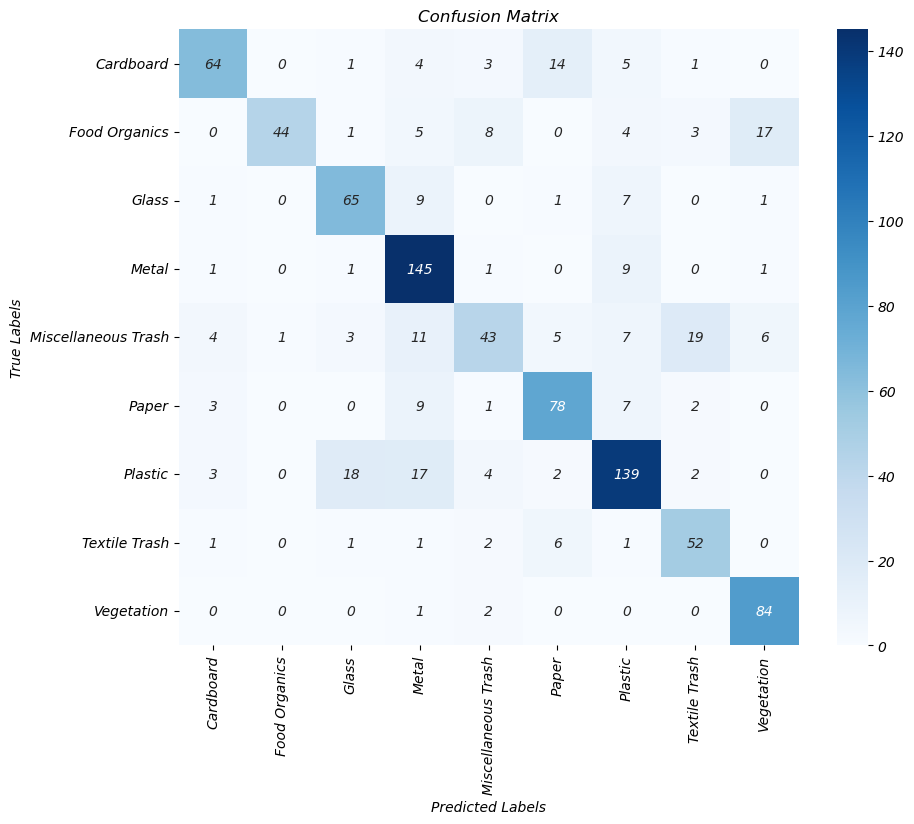

Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.83      0.70      0.76        92
      Food Organics       0.98      0.54      0.69        82
              Glass       0.72      0.77      0.75        84
              Metal       0.72      0.92      0.81       158
Miscellaneous Trash       0.67      0.43      0.53        99
              Paper       0.74      0.78      0.76       100
            Plastic       0.78      0.75      0.76       185
      Textile Trash       0.66      0.81      0.73        64
         Vegetation       0.77      0.97      0.86        87

           accuracy                           0.75       951
          macro avg       0.76      0.74      0.74       951
       weighted avg       0.76      0.75      0.74       951



In [ ]:
# Path to saved model
model_path = r"C:\Users\Gabriel\Documents\Green AI\realwaste\realwaste-main\RealWaste\waste_classifier.h5"

# Load the trained model
model = load_model(model_path)

# Directory of validation images
val_dir = os.path.join(base_dir, "test")  # ou ton dossier de validation

# Create validation generator with correct preprocessing
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False  # Important pour garder l'ordre des labels
)

# Reset generator
val_generator.reset()

# Predict on validation set
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = val_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_labels = list(val_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))



We got 0.75 of accuracy which is good score for pictures recognition

So now let's improve

# Thank u for following our study